Le code suivant est basé, quasiment dans son intégralité ( des modifications ont été apportées au besoin) , sur les codes disponbles via ces liens:
https://machinelearningmastery.com/how-to-grid-search-deep-learning-models-for-time-series-forecasting/
https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

In [0]:
import matplotlib.pyplot as plt
import math
from operator import itemgetter
import time
from math import sqrt
from numpy import *
from sklearn.preprocessing import MinMaxScaler
from numpy import mean
from pandas import DataFrame,concat,read_csv, Series
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,model_from_json
from keras.layers import Dense,LSTM

Using TensorFlow backend.


In [0]:
# split a univariate dataset into train/test sets
def train_test_split(data, train_size):
  train = dataset[0:train_size, ]
  test = dataset[train_size:len(dataset), ]
  return train, test

In [0]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# Construction et entrainement du modèle

In [0]:
def model_fit(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch= config	
  # transform series into supervised format
  data = series_to_supervised(train, n_in=n_input)
  # separate inputs and outputs
  train_x, train_y = data[:, :-1], data[:, -1]                #x: la séquence (de taille n_in(le nombre de "timsteps" passées à utiliser pour la prédiction)) , y: le "timestep" cible
  
  # reshape input data into [samples, timesteps, features]
  n_features = 1
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  # fit model
  start = time.time()
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=7)
  print("Temps d'entrainement =   %s s" % (time.time() - start))
  return model

# model.add(SimpleRNN(units=4, input_shape=(trainX.shape[1], trainX.shape[2])))

# Calcul RMSE

In [0]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# Prédiction

In [0]:
# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]
 

# Validation Walk Forward

In [0]:
# walk-forward validation for univariate data
def walk_forward_validation(data, train_size, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data,train_size)
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  #invert predictions and test 
  predictions = scaler.inverse_transform(predictions)
  test = scaler.inverse_transform(test)
  # estimate prediction error
  error = measure_rmse(test, predictions)
  print('> %s RMSE %.3f' %(str(cfg) , error))
  return error,model

In [0]:
# score a model, return None on failure
def repeat_evaluate(data, config, train_size, n_repeats=3):
  # convert config to a key	
  # fit and evaluate the model n times
  scores = [walk_forward_validation(data, train_size, config) for _ in range(n_repeats)]
  # summarize score
  
  result = mean([t[0] for t in scores])
  print('> Model[%s] %.3f' % (str(config), result))
  return (config, result, scores[-1][1])    # la configuration courante, la moyenne des erreures et le dernier modèle évalué

# Grille de recherche 


In [0]:
# grid search configs
def grid_search(data, cfg_list, train_size):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, train_size) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=itemgetter(1))
	return scores                              # retourne une liste de tuples où chaque tuple est de la forme (config,resultat,dernier modèle évalué dans model_evaluate())

# Définition des configurations de test

In [0]:
# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [3,7,30]
	n_nodes = [4,50,100]
	n_epochs = [80]         # les nombres d'épochs ont été fixés sur base d'autres exécutions faites préalablement à cette grille de recherche
	n_batch = [1]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
						cfg = [i, j, k, l]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# Execution
**Entrées**: fichier csv de la série temporelle 

Le meilleur modèle retourné par la grille de recherche peut etre rechargé.
Un autre modèle peut etre réajusté:

**Paramètres à renseigner** : (dans la fonction model_config() ci-dessus)

- n_input : nombre d'observations antérieures à considérer.
- n_nodes : nombre 
- n_epochs : nombre d'epochs
- n_batch : taille du batch

Pour évaluer d'autres modèles donner la liste des valeurs des paramètres.
Pour ajuster un seul autre modèle, spécifier une seule valeur pour chaque paramètre.

- La proportion de l'ensemble d'entrainement est à spécifier avec "train_proportion" dans la cellule "chargement des données"

**Sorties**: le meilleur modèle de la grille peut etre sauvegardé.
Ce modèle peut etre invoqué pour calculer les prédictions d'un ensemble de données (le prétraitement est donné dans les cellules suivantes) 

Le modèle retourne la prédiction t (n_input +1) pour une séquence antérieure (t(1) - t(n_input))

## Chargement des données

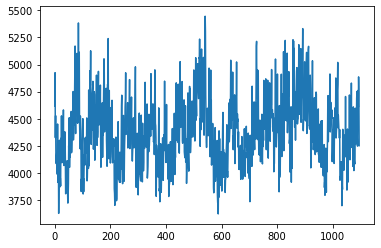

Total configs: 9
Epoch 1/80
Epoch 2/80
Epoch 3/80
Epoch 4/80
Epoch 5/80
Epoch 6/80
Epoch 7/80
Epoch 8/80
Epoch 9/80
Epoch 10/80
Epoch 11/80
Epoch 12/80
Epoch 13/80
Epoch 14/80
Epoch 15/80
Epoch 16/80
Epoch 17/80
Epoch 18/80
Epoch 19/80
Epoch 20/80
Epoch 21/80
Epoch 22/80
Epoch 23/80
Epoch 24/80
Epoch 25/80
Epoch 26/80
Epoch 27/80
Epoch 28/80
Epoch 29/80
Epoch 30/80
Epoch 31/80
Epoch 32/80
Epoch 33/80
Epoch 34/80
Epoch 35/80
Epoch 36/80
Epoch 37/80
Epoch 38/80
Epoch 39/80
Epoch 40/80
Epoch 41/80
Epoch 42/80
Epoch 43/80
Epoch 44/80
Epoch 45/80
Epoch 46/80
Epoch 47/80
Epoch 48/80
Epoch 49/80
Epoch 50/80
Epoch 51/80
Epoch 52/80
Epoch 53/80
Epoch 54/80
Epoch 55/80
Epoch 56/80
Epoch 57/80
Epoch 58/80
Epoch 59/80
Epoch 60/80
Epoch 61/80
Epoch 62/80
Epoch 63/80
Epoch 64/80
Epoch 65/80
Epoch 66/80
Epoch 67/80
Epoch 68/80
Epoch 69/80
Epoch 70/80
Epoch 71/80
Epoch 72/80
Epoch 73/80
Epoch 74/80
Epoch 75/80
Epoch 76/80
Epoch 77/80
Epoch 78/80
Epoch 79/80
Epoch 80/80
Temps d'entrainement =   649.262

In [0]:
random.seed(7)
data = read_csv('/content/drive/My Drive/TER/pass.csv', delimiter=';', usecols=[1], skiprows=0, encoding="utf-8")
# print(data)
plt.plot(data)
plt.show()
dataset = data.values
dataset = data.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# plt.plot(dataset)
# plt.show()
train_proportion=0.67
train_size = int(len(dataset) * train_proportion)
cfg_list = model_configs()


## Execution de la grille de recherche

In [0]:
# grid search
scores = grid_search(data, cfg_list, train_size)
print('fin de la grille de rechrche')

## Résumé des résultats

In [0]:
# list top 10 configs

print("format des configurations: configuration [n_input,n_nodes,n_epochs,n_batch]")
for t in scores:
  cfg,score, model = t
  print("config %s  RMSE %.3f" %(str(cfg),score))

bestconfig,_,bestmodel=scores[1]

# serialize model to JSON
model_json = model.to_json()
path='/content/drive/My Drive/TER/'
modelname='LSTM_with_timesteps'+str(bestconfig)      # si n_input =1 without window
with open(path+modelname+'.json', "w") as json_file:
  json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(path+modelname+'.h5')


## Meilleur modèle retourné par la grille
### (Sinon charger le modèle sauvegardé)

In [0]:
# load json and create model

json_file = open('/content/drive/My Drive/TER/simpleRNN[30, 100, 50, 150].json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/TER/simpleRNN[30, 100, 50, 150].h5")
print("Loaded model from disk")

### RMSE sur les données test 

In [0]:
# bestconfig=[30, 100, 50, 150]
# bestmodel=loaded_model
n_input, n_nodes, n_epochs, n_batch= bestconfig	          
n_features = 1
# les données dans le format défini plus haut 
#1- séparation train et test
train, test = train_test_split(dataset,train_size)
#2- format apprentissage supérvisé
trainS = series_to_supervised(train, n_in=n_input)
testS = series_to_supervised(test, n_in=n_input)
train_x, train_y = trainS[:, :-1], trainS[:, -1] 
test_x, test_y = testS[:, :-1], testS[:, -1] 
#3- format [samples,timesteps,features]
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], n_features))

#Prediction
y_train_pred=yhat = bestmodel.predict(train_x, verbose=0)
y_test_pred=bestmodel.predict(test_x, verbose=0)

# inversion de la transformation MinMaxScaler
y_train_pred_orig = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred_orig = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_orig = scaler.inverse_transform(train_y.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(test_y.reshape(-1, 1))

# score sur l'ensemble test
testScore = measure_rmse(y_test_orig, y_test_pred_orig)
print('RMSE Ensemble test: %.3f  ' % (testScore))



### Visualisation des prédictions/données réelles

In [0]:
# Visulaisation

trainPredictPlot = empty_like(dataset)
trainPredictPlot[:, :] = nan
trainPredictPlot[n_input:len(y_train_pred) + n_input, :] = y_train_pred_orig

# shift test predictions for plotting
testPredictPlot = empty_like(dataset)
testPredictPlot[:, :] = nan
testPredictPlot[len(y_train_pred) + (n_input * 2):len(dataset), :] = y_test_pred_orig

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Original Data', color='c')
plt.plot(trainPredictPlot, label='y_train_pred', color='m')
plt.plot(testPredictPlot, label='y_test_pred', color='b')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Nb de Passages')
plt.show()